In [1]:
# Cargar Datos CSV
import pandas as pd
data = pd.read_csv('DatosSingapore2.csv')

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Detectar columnas binarias
binary_vars = [col for col in data.columns 
               if set(data[col].dropna().unique()).issubset({0, 1})]

# 2. Detectar columnas numéricas verdaderas
numerical_vars = data.select_dtypes(include=['number']).columns
numerical_true = [col for col in numerical_vars if col not in binary_vars]

# 3. Features
X = data[binary_vars + numerical_true]

# 4. Escalar únicamente numéricas continuas
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numerical_true] = scaler.fit_transform(X[numerical_true])

# 🔥 PASO CRÍTICO: convertir todo a float32
X_scaled = X_scaled.astype("float32")

# 5. Target
y = data["price"].astype("float32")

# 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Verificar NaNs en los conjuntos de datos
nan_counts = pd.DataFrame({
    "train": X_train.isna().sum(),
    "test": X_test.isna().sum()
})

print(nan_counts[nan_counts.sum(axis=1) > 0])

Empty DataFrame
Columns: [train, test]
Index: []


In [ ]:
import tensorflow as tf
from tensorflow import keras

def create_model(n_neurons=64, n_layers=2, lr=0.001, dropout_rate=0.0,
                 hidden_activation="relu", output_activation="linear"):
    
    model = keras.Sequential()
    
    # Capa de entrada
    model.add(keras.layers.Input(shape=(X_train.shape[1],)))

    # Capas ocultas
    for _ in range(n_layers):
        model.add(keras.layers.Dense(n_neurons, activation=hidden_activation))
        if dropout_rate > 0:
            model.add(keras.layers.Dropout(dropout_rate))

    # Capa de salida
    model.add(keras.layers.Dense(1, activation=output_activation))

    # Compilar
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="mean_squared_error",
        metrics=["mean_absolute_error"]
    )
    
    return model

In [ ]:
import mlflow
import mlflow.tensorflow
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mlflow.set_experiment("Airbnb_price_regression")

def train_and_log(params):
    n_neurons = params["n_neurons"]
    n_layers = params["n_layers"]
    lr = params["lr"]
    dropout = params["dropout"]
    hidden_activation = params["hidden_activation"]
    output_activation = params["output_activation"]

    with mlflow.start_run():

        # Registrar parámetros del modelo
        mlflow.log_params(params)

        # Crear modelo
        model = create_model(
            n_neurons=n_neurons,
            n_layers=n_layers,
            lr=lr,
            dropout_rate=dropout,
            hidden_activation=hidden_activation,
            output_activation=output_activation
        )

        # Entrenamiento
        history = model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=50,
            batch_size=32,
            verbose=0
        )

        # Predicción
        preds = model.predict(X_test).flatten()

        # Métricas
        mse = mean_squared_error(y_test, preds)
        rmse = math.sqrt(mse)
        mae = mean_absolute_error(y_test, preds)

        # Registrar métricas
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)

        # Registrar activaciones usadas
        mlflow.log_param("hidden_activation", hidden_activation)
        mlflow.log_param("output_activation", output_activation)

        # Guardar modelo en MLflow
        mlflow.tensorflow.log_model(model, "model")

        print(f"✔ Run logged — RMSE: {rmse:.2f}, MAE: {mae:.2f}, MSE: {mse:.2f}")

In [ ]:
from itertools import product

# ============================
# Definir espacio de búsqueda
# ============================

param_grid = {
    "n_neurons":        [32, 64, 128],
    "n_layers":         [1, 2, 3],
    "lr":               [0.001, 0.0005],
    "dropout":          [0.0, 0.2],
    "hidden_activation": ["relu", "tanh", "elu"],
    "output_activation": ["linear", "relu"]
}

# Crear todas las combinaciones
search_space = []

for values in product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), values))
    search_space.append(params)

print(f"Total de combinaciones: {len(search_space)}")

# ============================
# Ejecutar grid search
# ============================

for params in search_space:
    print(f"\n🚀 Ejecutando configuración: {params}")
    train_and_log(params)


## MEJOR MODELO

Epoch 1/200
62/62 [==============================] - 2s 13ms/step - loss: 70041.8906 - mean_absolute_error: 213.0576 - val_loss: 48944.2617 - val_mean_absolute_error: 172.9248
Epoch 2/200
62/62 [==============================] - 0s 6ms/step - loss: 22263.6641 - mean_absolute_error: 104.5642 - val_loss: 9085.1689 - val_mean_absolute_error: 70.5536
Epoch 3/200
62/62 [==============================] - 0s 6ms/step - loss: 7300.9087 - mean_absolute_error: 60.5349 - val_loss: 6736.1924 - val_mean_absolute_error: 59.3564
Epoch 4/200
62/62 [==============================] - 0s 5ms/step - loss: 5321.2993 - mean_absolute_error: 50.4184 - val_loss: 4815.6016 - val_mean_absolute_error: 49.2951
Epoch 5/200
62/62 [==============================] - 0s 6ms/step - loss: 3672.8289 - mean_absolute_error: 41.4186 - val_loss: 3161.8611 - val_mean_absolute_error: 40.6676
Epoch 6/200
62/62 [==============================] - 0s 6ms/step - loss: 2284.1001 - mean_absolute_error: 32.7671 - val_loss: 1856.1621 - 

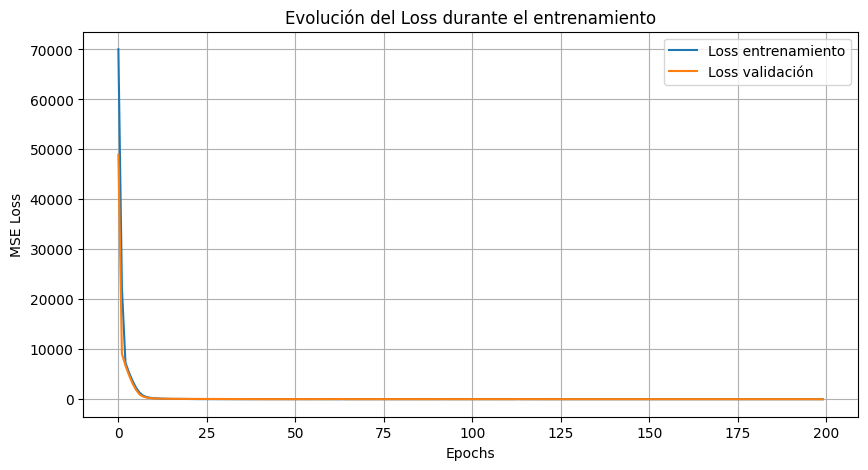

16/16 [==============================] - 0s 2ms/step - loss: 5.9880 - mean_absolute_error: 1.5517

Resultados finales:
MSE: 5.9880
MAE: 1.5517


In [3]:

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# ============================
# 1. Crear modelo Keras
# ============================
def create_model():
    model = keras.Sequential()

    # Input
    model.add(keras.layers.Input(shape=(X_train.shape[1],)))

    # 2 capas ocultas de 128 neuronas con activación ELU
    for _ in range(2):
        model.add(keras.layers.Dense(128, activation="elu"))

    # Capa de salida lineal
    model.add(keras.layers.Dense(1, activation="linear"))

    # Compilación
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss="mean_squared_error",
        metrics=["mean_absolute_error"]
    )
    
    return model


# ============================
# 2. Entrenar modelo
# ============================
model = create_model()

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    verbose=1
)

# ============================
# 3. Graficar Loss vs Epochs
# ============================
plt.figure(figsize=(10,5))
plt.plot(history.history["loss"], label="Loss entrenamiento")
plt.plot(history.history["val_loss"], label="Loss validación")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Evolución del Loss durante el entrenamiento")
plt.legend()
plt.grid(True)
plt.show()

# ============================
# 4. Evaluar modelo
# ============================
mse, mae = model.evaluate(X_test, y_test)
print("\nResultados finales:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
